In [1]:
import pandas as pd
import numpy as np
import random
import scipy.optimize as scopt

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

In [2]:
from supplement_package.game.gradient import GradientComputation
from supplement_package.game.player import Player
from supplement_package.game.stackelberg import StackelbergPlayer
from supplement_package.game.stackelberg import StackelbergGradientComputation

In [3]:
StackelbergGradientComputation.__dict__

mappingproxy({'__module__': 'supplement_package.game.stackelberg',
              '__init__': <function supplement_package.game.stackelberg.StackelbergGradientComputation.__init__(self) -> None>,
              'risk_utility_grad': <staticmethod at 0x145c1aeb0>,
              'stackelberg_penalty_residual': <staticmethod at 0x145c1aee0>,
              'penalty_jmin': <staticmethod at 0x145c1af10>,
              'penalty_jmax': <staticmethod at 0x145c1af40>,
              'penalty_risk_balance': <staticmethod at 0x145c1af70>,
              '__doc__': None})

In [4]:
community_size = 3
variant = 1
simple_test = False

In [5]:
if variant == 1:
    D_min = [0.0,0.0,0.0]
    D_max = [10.0,10.0,10.0]

    G_min = [0.0,0.0,0.0]
    G_max = [10.0,0.0,0.0]
    
    Kappa = [[0.0, 10.0, 10.0],
             [10.0, 0.0, 5.0],
             [10.0, 5.0, 0.0]]
    
    Cost = [[0.0, 1.0, 1.0],
            [3.0, 0.0, 1.0],
            [2.0, 1.0, 0.0]]
    
    probabilities = [0.333, 0.333, 0.333]

    #probabilities = [1]
    connection_matrix = [[0,1,1],[1,0,1],[1,1,0]]

In [6]:
if variant == 2:
    D_min = [0.0,0.0,0.0]
    D_max = [0.0,0.0,0.0]

    G_min = [0.0,0.0,0.0]
    G_max = [0.0,0.0,0.0]
    
    Kappa = [[0.0,0.0,0.0],
             [0.0,0.0,0.0],
             [0.0,0.0,0.0]]
    
    Cost = [[0.0, 1.0, 1.0],
            [3.0, 0.0, 1.0],
            [2.0, 1.0, 0.0]]
    
    probabilities = [0.333, 0.333, 0.333]

    #probabilities = [1]
    connection_matrix = [[0,1,1],[1,0,1],[1,1,0]]

In [7]:
A_tilde = [random.uniform(0,1) for i in range(community_size)]
B_tilde = [random.uniform(0,1) for i in range(community_size)]

a = [random.uniform(0,1) for i in range(community_size)]
b = [random.uniform(0,1) for i in range(community_size)]
d = [random.uniform(0,1) for i in range(community_size)]

d_target = [[random.uniform(0,8) for j in range(len(probabilities))] for i in range(community_size)]
g_res = [[random.uniform(0,3) for j in range(len(probabilities))] for i in range(community_size)]

g_res = np.array(g_res)
d_target = np.array(d_target)

risk_aversion = [random.uniform(0,1) for i in range(community_size)]

In [8]:
A_tilde = [0.36030143572119644, 0.8194188912652529, 0.7073792742889289]
B_tilde = [0.43213666201039447, 0.3942880799602334, 0.8721268085292664]

a = [0.5353027996733363, 0.2743886024182589, 0.6880650530486562]
b = [0.048638223979889705, 0.18135310781459213, 0.0550926893600856]
d = [0.25656978557764465, 0.27860408681196946, 0.23100499807342023]

#d_target = [[2.1263784908116197], [6.103873263111134], [4.110550414075242]]
#g_res = [[0.5151806223322815], [0.7797232173334425], [1.4297130854390094]]
risk_aversion = [0.06910997716902567, 0.7617642865089619, 0.9838119468874024]

In [9]:
if simple_test == True:
    #A_tilde = [1,2,3]
    #B_tilde = [1,2,3]
    A_tilde = [0,0,0]
    B_tilde = [0,0,0]

    #a = [1,2,3]
    #b = [1,2,3]
    #d = [1,2,3]
    a = [0,0,0]
    b = [0,0,0]
    d = [0,0,0]

    d_target = [[1], [2], [3]]
    g_res = [[1], [2], [3]]
    risk_aversion = [0.5, 0.5, 0.5]

In [10]:
if variant == 2:
    g_res = [[0.0,0.0,0.0] for i in range(community_size)]
    d_target = [[0.0,0.0,0.0] for i in range(community_size)]

In [11]:
agents = []
StackelbergPlayer.community_size = community_size
StackelbergPlayer.probabilities = probabilities

epsilon = 0.001
alpha = [[proba/(1 - risk_aversion[i]) for proba in probabilities] for i in range(community_size)]
#alpha = [[0.2 for proba in probabilities] for i in range(community_size)]
gamma = [proba/(1 - min(risk_aversion)) for proba in probabilities]

j_max = [10 for i in range(community_size)]

for i in range(community_size):
    agent = StackelbergPlayer(i, d_target[i], g_res[i], a[i], b[i], d[i], 
                A_tilde[i], B_tilde[i], D_min[i], D_max[i], 
                G_min[i], G_max[i], risk_aversion[i], Kappa[i], Cost[i], connection_matrix[i],
                probabilities = probabilities,
                alpha = alpha[i], 
                gamma = gamma, 
                insurance_bound=j_max[i])
    
    agents.append(agent)

In [12]:
agents[0].__dict__

{'id': 0,
 'D_target': array([1.3827677 , 0.08358222, 3.42654849]),
 'G_res': array([2.89525613, 2.24829753, 0.50272594]),
 'a': 0.5353027996733363,
 'b': 0.048638223979889705,
 'd': 0.25656978557764465,
 'a_tilde': 0.36030143572119644,
 'b_tilde': 0.43213666201039447,
 'D_min': 0.0,
 'D_max': 10.0,
 'G_min': 0.0,
 'G_max': 10.0,
 'risk_aversion': 0.06910997716902567,
 'probabilities': [0.333, 0.333, 0.333],
 'probabilities_ind': [0, 1, 2],
 'trading_cost': [0.0, 1.0, 1.0],
 'connections': [0, 1, 1],
 'kappa': array([ 0., 10., 10.]),
 'G': array([0., 0., 0.]),
 'D': array([0., 0., 0.]),
 'eta': 0,
 'u': array([0., 0., 0.]),
 'q': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'grad_G': array([0., 0., 0.]),
 'grad_D': array([0., 0., 0.]),
 'grad_eta': 0,
 'grad_u': array([0., 0., 0.]),
 'grad_q': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'q_others': {},
 'w_others': {},
 'plot_d': [[], [], []],
 'plot_g': [[], [], []],
 'plot_u': [[], [], [

## Gurobi

In [13]:
import gurobipy as gp
from supplement_package.gurobi_implementation.gurobi import Gurobi
from supplement_package.gurobi_implementation.gurobi import GurobiSolution
from supplement_package.gurobi_implementation.gurobi import BRGS

In [14]:
model_1 = gp.Model()
setup = GurobiSolution(agents=agents,
                model = model_1,
                solution_type='centralized')

setup.build_model()

model_1.display()

Set parameter Username
Academic license - for non-commercial use only - expires 2022-04-02
Minimize
<gurobi.LinExpr: eta_0 + 0.3577221710759105 W_0_0 + 0.3577221710759105 W_0_1
+ 0.3577221710759105 W_0_2 + 0.3577221710759105 J_0_0 + 0.3577221710759105 J_0_1
+ 0.3577221710759105 J_0_2 + 0.3577221710759105 u_0_0 + 0.3577221710759105 u_0_1
+ 0.3577221710759105 u_0_2 + eta_1 + 0.3577221710759105 W_1_0 + 0.3577221710759105 W_1_1
+ 0.3577221710759105 W_1_2 + 1.3977753172281062 J_1_0 + 1.3977753172281062 J_1_1
+ 1.3977753172281062 J_1_2 + 1.397775317228106 u_1_0 + 1.397775317228106 u_1_1
+ 1.397775317228106 u_1_2 + eta_2 + 0.3577221710759105 W_2_0 + 0.3577221710759105 W_2_1
+ 0.3577221710759105 W_2_2 + 20.570725687875186 J_2_0 + 20.570725687875186 J_2_1
+ 20.570725687875186 J_2_2 + 20.570725687875186 u_2_0 + 20.570725687875186 u_2_1
+ 20.570725687875186 u_2_2>
Subject To
  Bilateral trading for pair (0, 1) proba 0: <gurobi.LinExpr: q_0_1_0 + q_1_0_0> = 0
  Bilateral trading for pair (0, 1) pr

In [15]:
model_1.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 30 rows, 66 columns and 81 nonzeros
Model fingerprint: 0xd74259b2
Model has 9 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e-01, 8e-01]
  QLMatrix range   [5e-02, 1e+01]
  Objective range  [4e-01, 2e+01]
  Bounds range     [5e+00, 1e+01]
  RHS range        [1e-01, 3e+00]
  QRHS range       [2e-01, 4e+01]
Presolve removed 9 rows and 6 columns
Presolve time: 0.00s
Presolved: 63 rows, 78 columns, 174 nonzeros
Presolved model has 9 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 12
 AA' NZ     : 1.770e+02
 Factor NZ  : 6.310e+02
 Factor Ops : 7.769e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.564056

In [16]:
model_1.getVars()

[<gurobi.Var D_0_0 (value 0.07893121911888713)>,
 <gurobi.Var D_0_1 (value 1.7956540646802656e-08)>,
 <gurobi.Var D_0_2 (value 0.49320823038244854)>,
 <gurobi.Var G_0_0 (value 1.6639511675155416)>,
 <gurobi.Var G_0_1 (value 0.8937398987037283)>,
 <gurobi.Var G_0_2 (value 3.8578657653284614)>,
 <gurobi.Var q_0_1_0 (value 1.179238194796623)>,
 <gurobi.Var q_0_1_1 (value 3.889585741729533)>,
 <gurobi.Var q_0_1_2 (value 5.086071243023717)>,
 <gurobi.Var q_0_2_0 (value -5.65951427138599)>,
 <gurobi.Var q_0_2_1 (value -7.031623152895788)>,
 <gurobi.Var q_0_2_2 (value -8.953454717896596)>,
 <gurobi.Var eta_0 (value -7.158036138651554)>,
 <gurobi.Var W_0_0 (value -2.4796193054167768)>,
 <gurobi.Var W_0_1 (value 4.100210953623053)>,
 <gurobi.Var W_0_2 (value -1.9711808720539596)>,
 <gurobi.Var J_0_0 (value 4.599214472970991)>,
 <gurobi.Var J_0_1 (value 3.489764571194068e-08)>,
 <gurobi.Var J_0_2 (value 3.7615703460603243)>,
 <gurobi.Var u_0_0 (value 1.8170953316526568)>,
 <gurobi.Var u_0_1 (val

## Best-Response Gauss-Seidel 

In [17]:
for k in range(1):
    for agent in agents:
        model = gp.Model()
        model.setParam('OutputFlag', 0)
        setup = GurobiSolution(agents = agents,
                                model = model,
                                solution_type = 'BRGS',
                                agent = agent)

        BRGS.pass_parameters(agent,agents)
        setup.build_model()
        model.optimize()
        BRGS.extract_parameters(agent, agents, model)
        
        agent.plot_eta.append(agent.eta)

        for i in range(len(probabilities)):
            agent.plot_d[i].append(agent.D[i])
            agent.plot_g[i].append(agent.G[i])
            agent.plot_u[i].append(agent.u[i])
            agent.plot_w[i].append(agent.w[i])
            agent.plot_j[i].append(agent.j[i])

            for agent_2 in agents:
                agent.plot_q[agent_2.id][i].append(agent.q[agent_2.id][i])

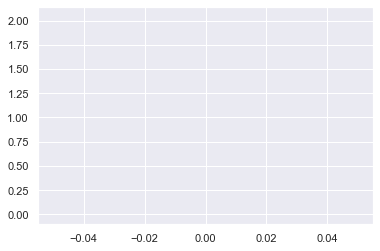

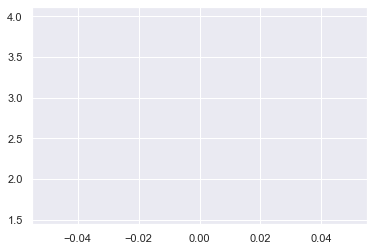

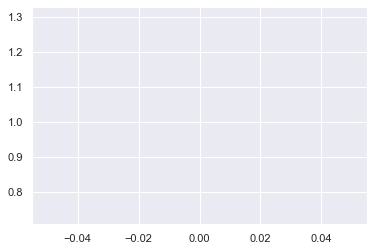

In [18]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(agent.plot_d[i])
    
    plt.show()

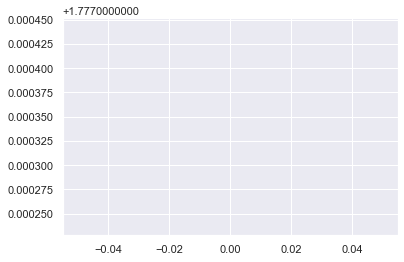

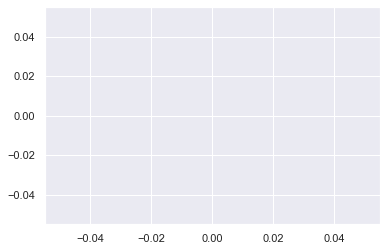

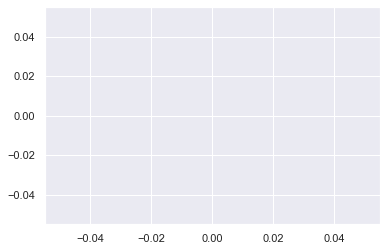

In [19]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(agent.plot_g[i])
    
    plt.show()

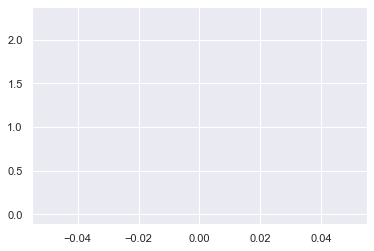

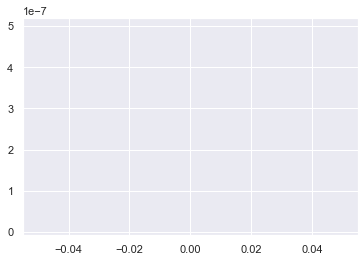

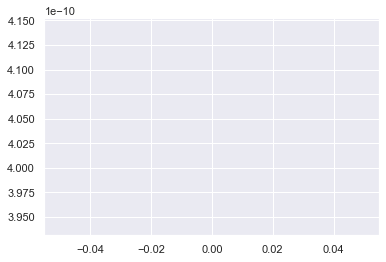

In [20]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(agent.plot_j[i])
    
    plt.show()

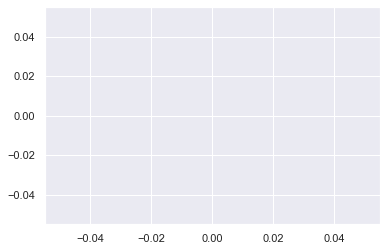

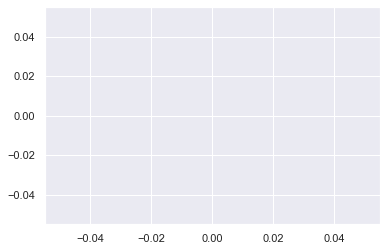

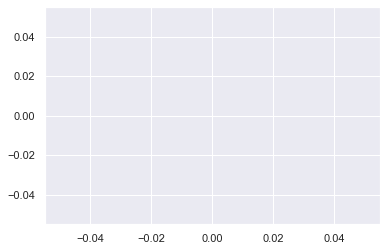

In [21]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(agent.plot_w[i])
    
    plt.show()

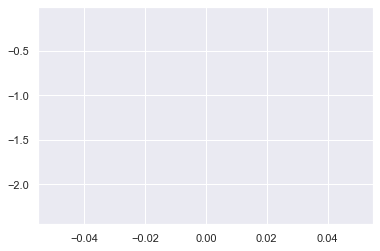

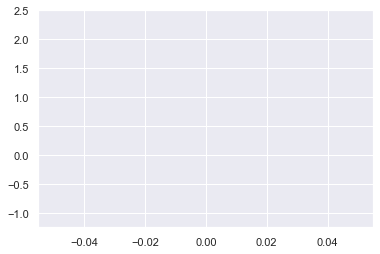

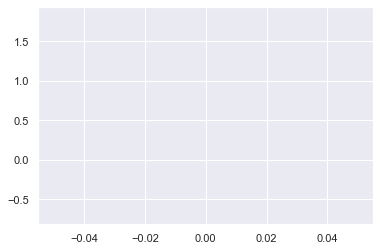

In [22]:
for agent in agents:
    for i in range(len(probabilities)):
        for agent_2 in agents:
            if agent.connections[agent_2.id]:
                plt.plot(agent.plot_q[agent_2.id][i])
    
    plt.show()

## AMPL

In [23]:
from amplpy import AMPL, Environment, DataFrame

ampl = AMPL(Environment('/Users/ishilov/Documents/ampl.macos64'))

ampl.read('/Users/ishilov/Documents/risk_paper/risk_paper/ampl/3_nodes_centr_risk.mod')
ampl.readData('/Users/ishilov/Documents/risk_paper/risk_paper/ampl/3_nodes_centr_risk.dat')


In [24]:
nodes = ['n_0', 'n_1', 'n_2']

In [25]:
Cost_dict = {}
for i in range(community_size):
    for j in range(community_size):
        Cost_dict.update({(nodes[i],nodes[j]):Cost[i][j]})

Kappa_dict = {}
for i in range(community_size):
    for j in range(community_size):
        Kappa_dict.update({(nodes[i],nodes[j]):Kappa[i][j]})

In [26]:
d_target_dict = {}
g_res_dict = {}
alpha_dict = {}
for i in range(community_size):
    for j in range(len(probabilities)):
        d_target_dict.update({('n_{}'.format(i), 'p_{}'.format(j)): d_target[i][j]})
        g_res_dict.update({('n_{}'.format(i), 'p_{}'.format(j)): g_res[i][j]})
        alpha_dict.update({('n_{}'.format(i), 'p_{}'.format(j)): alpha[i][j]})

In [27]:
for agent in agents:
    print(agent.G_res)

[2.89525613 2.24829753 0.50272594]
[1.65867878 2.91454574 2.35188819]
[0.11592936 2.2813248  0.37504137]


In [28]:
g_res_dict

{('n_0', 'p_0'): 2.8952561281927793,
 ('n_0', 'p_1'): 2.2482975304187205,
 ('n_0', 'p_2'): 0.5027259399294237,
 ('n_1', 'p_0'): 1.658678780789261,
 ('n_1', 'p_1'): 2.914545741971315,
 ('n_1', 'p_2'): 2.351888189670447,
 ('n_2', 'p_0'): 0.11592935698388074,
 ('n_2', 'p_1'): 2.281324802297712,
 ('n_2', 'p_2'): 0.37504136746821126}

In [29]:
p_dict = {}
for j in range(len(probabilities)):
    p_dict.update({'p_{}'.format(j) : probabilities[j]})

In [30]:
if community_size == 3:

    ampl.getParameter('a').setValues(a)
    ampl.getParameter('b').setValues(b)
    ampl.getParameter('d').setValues(d)
    ampl.getParameter('a_t').setValues(A_tilde)
    ampl.getParameter('b_t').setValues(B_tilde)

    ampl.getParameter('gamma').setValues(gamma)
    ampl.getParameter('alpha').setValues(alpha_dict)
    ampl.getParameter('J_max').setValues(j_max)

    ampl.getParameter('D_max').setValues(D_max)
    ampl.getParameter('G_max').setValues(G_max)
    ampl.getParameter('D_min').setValues(D_min)
    ampl.getParameter('G_min').setValues(G_min)

    ampl.getParameter('chi').setValues(risk_aversion)
    
    ampl.getParameter('cost').setValues(Cost_dict)

    ampl.getParameter('kappa').setValues(Kappa_dict)
    
    ampl.getParameter('p').setValues(p_dict)
                
    ampl.getParameter('D_t').setValues(d_target_dict)
    ampl.getParameter('G_d').setValues(g_res_dict)

In [31]:
ampl.display('chi')

chi [*] :=
n_0  0.06911
n_1  0.761764
n_2  0.983812
;



In [32]:

# Solve
ampl.setOption('solver', 'Gurobi')
ampl.solve()

Gurobi 9.5.0: Set parameter Username
optimal solution; objective 8.068164492
10 barrier iterations
No basis.
No dual variables returned.


In [33]:
if community_size ==3:
    g_ampl = ampl.getVariable('G').getValues().toDict()
    d_ampl = ampl.getVariable('D').getValues().toDict()
    u_ampl = ampl.getVariable('u').getValues().toDict()
    eta_ampl = ampl.getVariable('eta').getValues().toDict()
    q_ampl = ampl.getVariable('quant').getValues().toDict()
    j_ampl = ampl.getVariable('J').getValues().toDict()
    w_ampl = ampl.getVariable('W').getValues().toDict()


In [34]:
ampl.display('W')

W :=
n_0 p_0   -2.47962
n_0 p_1    4.10021
n_0 p_2   -1.97118
n_1 p_0    6.03371
n_1 p_1   -2.78512
n_1 p_2   -3.15981
n_2 p_0   -3.55409
n_2 p_1   -1.31509
n_2 p_2    5.13099
;



In [35]:
w_ampl

{('n_0', 'p_0'): -2.4796188083219968,
 ('n_0', 'p_1'): 4.100211450720949,
 ('n_0', 'p_2'): -1.9711803749647976,
 ('n_1', 'p_0'): 6.033711230156066,
 ('n_1', 'p_1'): -2.7851248061339446,
 ('n_1', 'p_2'): -3.1598092714216435,
 ('n_2', 'p_0'): -3.5540924218340693,
 ('n_2', 'p_1'): -1.315086644587005,
 ('n_2', 'p_2'): 5.130989646386441}

In [36]:
def assign_ampl(d, g, eta, u, q, w, J, agents):
    """Assigns the solution from AMPL to agents"""

    for i in range(community_size):
        id = 'n_{}'.format(i)

        for j in range(len(probabilities)):
            proba = 'p_{}'.format(j)
            agents[i].D[j] = d[(id, proba)]

    for i in range(community_size):
        id = 'n_{}'.format(i)

        for j in range(len(probabilities)):
            proba = 'p_{}'.format(j)
            agents[i].w[j] = w[(id, proba)]

    for i in range(community_size):
        id = 'n_{}'.format(i)

    for j in range(len(probabilities)):
        proba = 'p_{}'.format(j)
        agents[i].j[j] = J[(id, proba)]

    for i in range(community_size):
        id = 'n_{}'.format(i)

    for j in range(len(probabilities)):
        proba = 'p_{}'.format(j)
        agents[i].G[j] = g[(id, proba)]

    for i in range(community_size):
        id = 'n_{}'.format(i)

        for j in range(len(probabilities)):
            proba = 'p_{}'.format(j)
            agents[i].u[j] = u[(id, proba)]

    for i in range(community_size):
        id = 'n_{}'.format(i)

        agents[i].eta = eta[id]

    for i in range(community_size):
        id_1 = 'n_{}'.format(i)

        for j in range(community_size):
            id_2 = 'n_{}'.format(j)

            for k in range(len(probabilities)):
                proba = 'p_{}'.format(k)

                agents[i].q[j][k] = q[(id_1, id_2, proba)]

In [37]:
assign_ampl(d_ampl, g_ampl, eta_ampl, u_ampl, q_ampl, w_ampl, j_ampl, agents)

## Gradient

In [38]:
agents = []
StackelbergPlayer.community_size = community_size
StackelbergPlayer.probabilities = probabilities

epsilon = 0.001
alpha = [[proba/(1 - risk_aversion[i]) - epsilon for proba in probabilities] for i in range(community_size)]
#alpha = [[0.2 for proba in probabilities] for i in range(community_size)]
gamma = [proba/(1 - min(risk_aversion)) for proba in probabilities]

j_max = [10 for i in range(community_size)]

for i in range(community_size):
    agent = StackelbergPlayer(i, d_target[i], 
                g_res[i], 
                a[i], 
                b[i], 
                d[i], 
                A_tilde[i], B_tilde[i], D_min[i], D_max[i], 
                G_min[i], G_max[i], risk_aversion[i], Kappa[i], Cost[i], connection_matrix[i],
                probabilities = probabilities,
                alpha = alpha[i], 
                gamma = gamma, 
                insurance_bound=j_max[i])
    
    agents.append(agent)

In [39]:
agents[0].__dict__

{'id': 0,
 'D_target': array([1.3827677 , 0.08358222, 3.42654849]),
 'G_res': array([2.89525613, 2.24829753, 0.50272594]),
 'a': 0.5353027996733363,
 'b': 0.048638223979889705,
 'd': 0.25656978557764465,
 'a_tilde': 0.36030143572119644,
 'b_tilde': 0.43213666201039447,
 'D_min': 0.0,
 'D_max': 10.0,
 'G_min': 0.0,
 'G_max': 10.0,
 'risk_aversion': 0.06910997716902567,
 'probabilities': [0.333, 0.333, 0.333],
 'probabilities_ind': [0, 1, 2],
 'trading_cost': [0.0, 1.0, 1.0],
 'connections': [0, 1, 1],
 'kappa': array([ 0., 10., 10.]),
 'G': array([0., 0., 0.]),
 'D': array([0., 0., 0.]),
 'eta': 0,
 'u': array([0., 0., 0.]),
 'q': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'grad_G': array([0., 0., 0.]),
 'grad_D': array([0., 0., 0.]),
 'grad_eta': 0,
 'grad_u': array([0., 0., 0.]),
 'grad_q': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'q_others': {},
 'w_others': {},
 'plot_d': [[], [], []],
 'plot_g': [[], [], []],
 'plot_u': [[], [], [

In [40]:
for i in range(community_size):
    print('Utility update:')
    print(StackelbergGradientComputation.utility_grad(agents[i]))
    print('-------')
    print('D_min bound')
    print(StackelbergGradientComputation.penalty_dmin(agents[i]))
    print('-------')
    print('D_max bound')
    print(StackelbergGradientComputation.penalty_dmax(agents[i]))
    print('-------')
    print('G_min bound')
    print(StackelbergGradientComputation.penalty_gmin(agents[i]))
    print('-------')
    print('G_max bound')
    print(StackelbergGradientComputation.penalty_gmax(agents[i]))
    print('-------')
    print('Penalty supply-demand balance bound')
    print(StackelbergGradientComputation.penalty_balance(agents[i]))
    print('-------')
    print('U bound')
    print(StackelbergGradientComputation.penalty_u(agents[i]))
    print('-------')
    print('Penalty trading bound')
    print(StackelbergGradientComputation.penalty_trading_bound(agents[i]))
    print('-------')
    print('Bilateral trading bound')
    print(StackelbergGradientComputation.penalty_bilateral_trading(agents[i], agents))
    print('-------')
    print('Penalty residual bound')
    print(StackelbergGradientComputation.penalty_residual(agents[i]))
    print('----------------------------------------------')

Utility update:
{'update_eta': 1, 'update_u': array([0.35772217, 0.35772217, 0.35772217])}
-------
D_min bound
[0. 0. 0.]
-------
D_max bound
[0 0 0]
-------
G_min bound
[0. 0. 0.]
-------
G_max bound
[0 0 0]
-------
Penalty supply-demand balance bound
{'update_d': array([-2.89525613, -2.24829753, -0.50272594]), 'update_g': array([2.89525613, 2.24829753, 0.50272594]), 'update_q': array([[0.        , 0.        , 0.        ],
       [2.89525613, 2.24829753, 0.50272594],
       [2.89525613, 2.24829753, 0.50272594]]), 'violation': array([-2.89525613, -2.24829753, -0.50272594])}
-------
U bound
[0. 0. 0.]
-------
Penalty trading bound
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
-------
Bilateral trading bound
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
-------
Penalty residual bound
{'update_d': array([ -0.51151172,  -0.        , -10.01207532]), 'update_g': array([0.02496825, 0.        , 0.19721909]), 'update_eta': -4.568163027716107, 'update_u': array([-0.51334623, -0.        , -4.0548168 ]), 'update_q'

In [41]:
mu = 0.09
rho = 900
k = 0

plot_penalty_residual = [[[] for j in range(len(probabilities))] for i in range(community_size)]
plot_balance = [[[] for j in range(len(probabilities))] for i in range(community_size)]

min_ra = min(risk_aversion)
while k <= 10000:
    #print(k)
    #print('--------------------------')
    for agent in agents:
        #Update of grad_d of the agent

        agent.grad_D = rho*(StackelbergGradientComputation.penalty_dmin(agent) 
                            + StackelbergGradientComputation.penalty_dmax(agent)
                            + StackelbergGradientComputation.penalty_balance(agent)['update_d']
                            + StackelbergGradientComputation.stackelberg_penalty_residual(agent)['update_d'])

        agent.grad_G = rho*(StackelbergGradientComputation.penalty_gmin(agent) 
                            + StackelbergGradientComputation.penalty_gmax(agent)
                            + StackelbergGradientComputation.penalty_balance(agent)['update_g']
                            + StackelbergGradientComputation.stackelberg_penalty_residual(agent)['update_g'])

        agent.grad_eta = (StackelbergGradientComputation.risk_utility_grad(agent, min_ra)['update_eta']
                            + rho*StackelbergGradientComputation.stackelberg_penalty_residual(agent)['update_eta'])

        agent.grad_u = (StackelbergGradientComputation.risk_utility_grad(agent, min_ra)['update_u']
                            + rho*StackelbergGradientComputation.stackelberg_penalty_residual(agent)['update_u']
                            + rho*StackelbergGradientComputation.penalty_u(agent))

        agent.grad_q = rho*(StackelbergGradientComputation.penalty_trading_bound(agent)
                            + StackelbergGradientComputation.stackelberg_penalty_residual(agent)['update_q']
                            + StackelbergGradientComputation.penalty_balance(agent)['update_q']
                            + StackelbergGradientComputation.penalty_bilateral_trading(agent, agents))

        agent.grad_w = (5 * StackelbergGradientComputation.risk_utility_grad(agent, min_ra)['update_w']
                            + 5 * rho * StackelbergGradientComputation.stackelberg_penalty_residual(agent)['update_w']
                            + 5 * rho * StackelbergGradientComputation.penalty_risk_balance(agents))

        agent.grad_j = (10 * StackelbergGradientComputation.risk_utility_grad(agent, min_ra)['update_j']
                            + 10 * rho * StackelbergGradientComputation.stackelberg_penalty_residual(agent)['update_j']
                            + 10 * rho * StackelbergGradientComputation.penalty_jmin(agent)
                            + 10 * rho * StackelbergGradientComputation.penalty_jmax(agent))
        

        #print('Agent {} variables'.format(agent.id))
        #print(agent.variables_to_vector())
        #print('--------------------------------')

    #Agent's variables update
    for agent in agents:

        N =  3000

        agent.D = agent.D - mu/(N)*agent.grad_D
        agent.G = agent.G - mu/(N)*agent.grad_G
        agent.eta = agent.eta - mu/(N)*agent.grad_eta
        agent.u = agent.u - mu/(N)*agent.grad_u
        agent.q = agent.q - mu/(N)*agent.grad_q
        agent.w = agent.w - 2 * mu/(N)*agent.grad_w
        agent.j = agent.j - 5 * mu/(N)*agent.grad_j

        agent.plot_eta.append(agent.eta)

        for i in range(len(probabilities)):
            agent.plot_d[i].append(agent.D[i])
            agent.plot_g[i].append(agent.G[i])
            agent.plot_u[i].append(agent.u[i])
            agent.plot_w[i].append(agent.w[i])
            agent.plot_j[i].append(agent.j[i])

            plot_penalty_residual[agent.id][i].append(StackelbergGradientComputation.stackelberg_penalty_residual(agent)['violation'])
            plot_balance[agent.id][i].append(StackelbergGradientComputation.penalty_balance(agent)['violation'])

            for agent_2 in agents:
                agent.plot_q[agent_2.id][i].append(agent.q[agent_2.id][i])
    
    

    k +=1

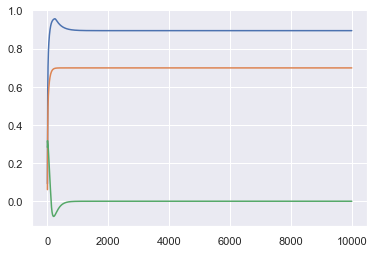

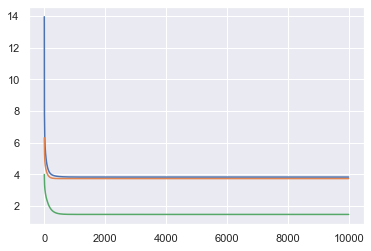

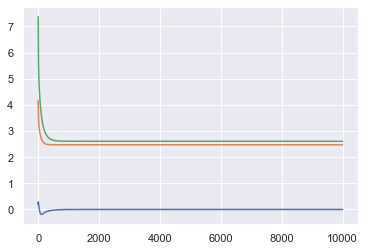

In [42]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(agent.plot_d[i])
    
    plt.show()

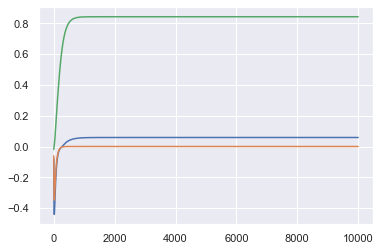

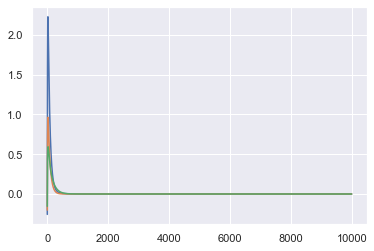

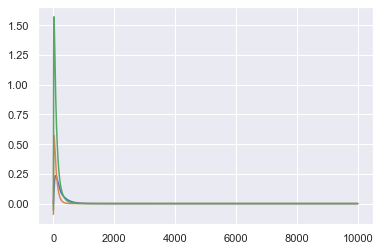

In [43]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(agent.plot_g[i])
    
    plt.show()

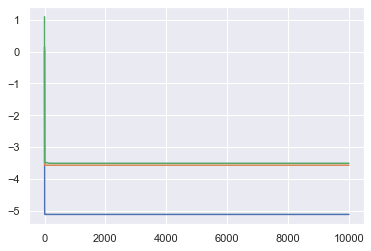

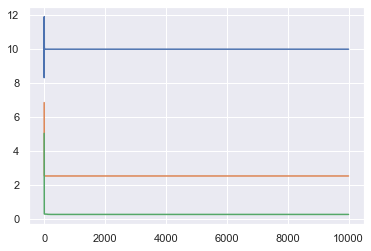

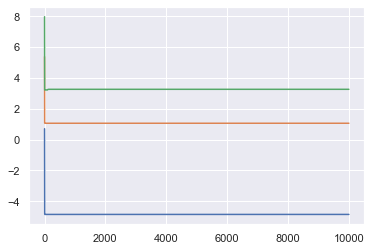

In [44]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(agent.plot_w[i])
    
    plt.show()

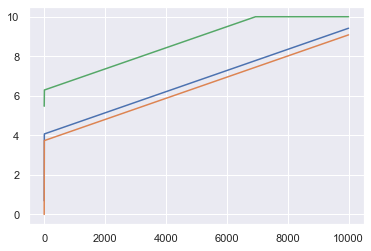

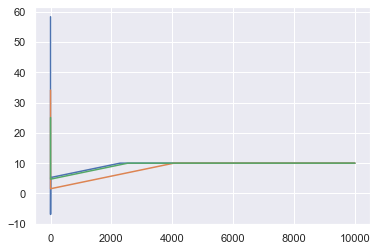

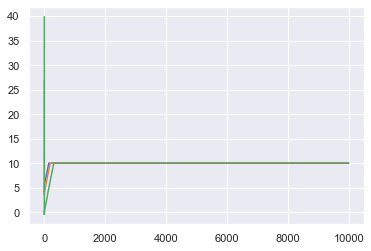

In [45]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(agent.plot_j[i])
    
    plt.show()

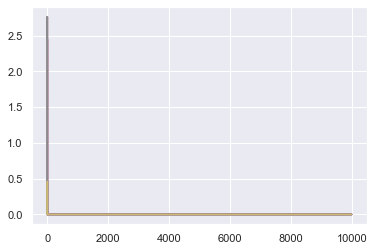

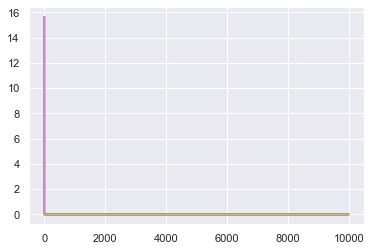

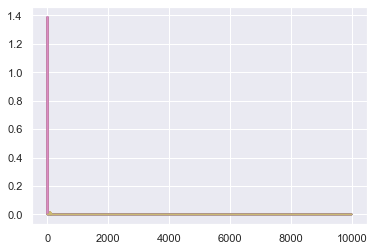

In [46]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(plot_penalty_residual[agent.id][i])
    
    plt.show()


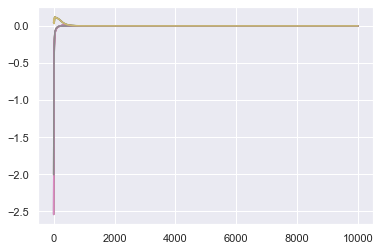

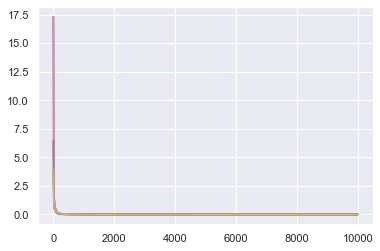

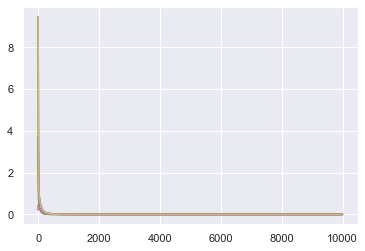

In [47]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(plot_balance[agent.id][i])
    
    plt.show()